# Data
## First approaches
### Imagery (Surface Reflectance)

In [ ]:
# description: https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance
# metadata: https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1618_Landsat-4-7_C2-L2-ScienceProductGuide-v4.pdf

In [1]:
import xarray as xr
import rioxarray as rxr

In [4]:
red = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Masterthesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_B3.TIF")
green = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Masterthesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_B2.TIF")
blue = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Masterthesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_B1.TIF")

In [ ]:
scaled_red = xr.where(red != 0, (red - 1) / (65535 - 1), 0)
scaled_green = xr.where(green != 0, (green - 1) / (65535 - 1), 0)
scaled_blue = xr.where(blue != 0, (blue - 1) / (65535 - 1), 0)

In [5]:
test = xr.combine_nested([green, red, blue], concat_dim = "band")

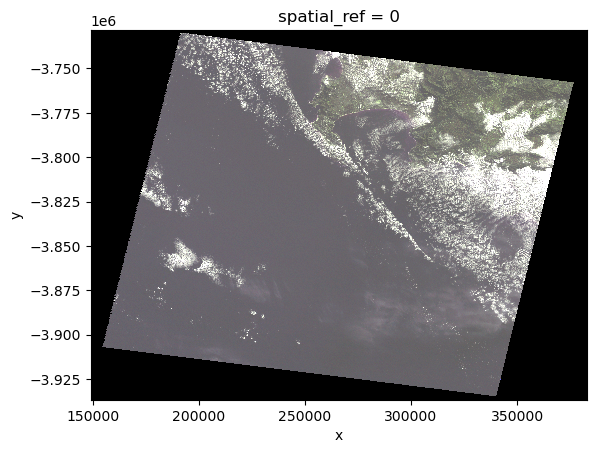

In [6]:
xr.plot.imshow(test, rgb = "band", robust = True)

In [63]:
cloud = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_CLOUD_QA.TIF")

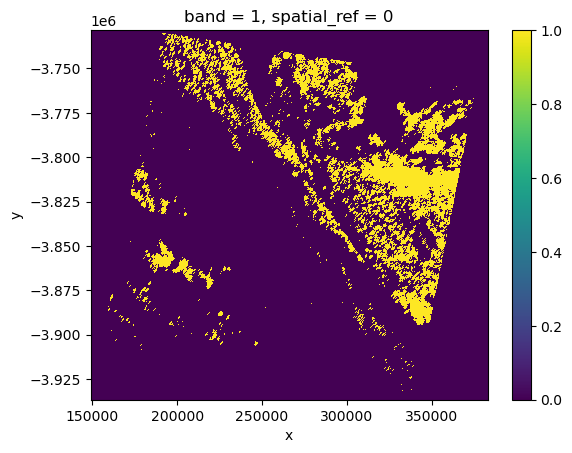

In [70]:
cloud.squeeze().isin([2, 34, 4, 12, 20, 36, 52, 8, 12, 24, 40, 56]).plot.imshow()

In [71]:
cloud_dist = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_ST_CDIST.TIF")

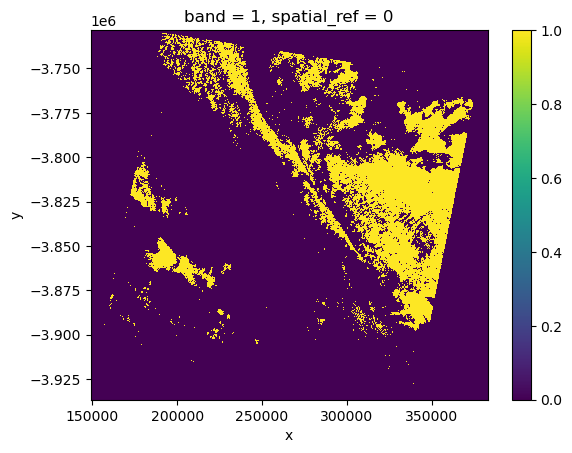

In [76]:
((cloud_dist.squeeze() > -5000) & (cloud_dist.squeeze() <= .1)).plot.imshow()

In [84]:
red_filtered = red.squeeze().where(cloud_dist.squeeze() > .1)

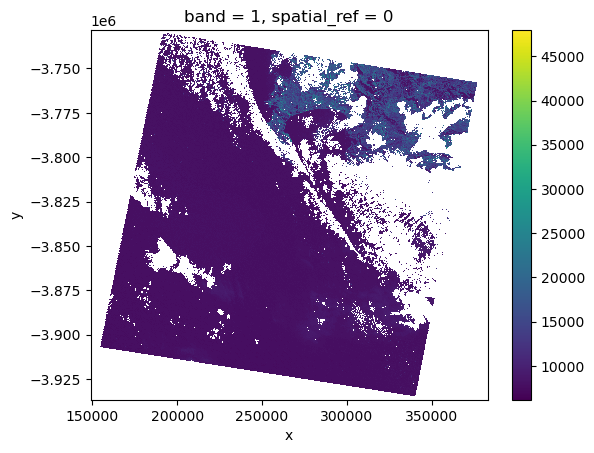

In [85]:
red_filtered.plot.imshow()

#### API

In [1]:
import requests
import geopandas as gpd
import shapely
import time

In [2]:
# login
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/login",
                         json = {"username": "felixschulz", "password": "wuJzid-5rutqo-dercib"})
API_key = response.json()["data"]

In [3]:
# get all datasets
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/dataset-search",
                         headers = {"X-Auth-Token": API_key})

In [4]:
([{x["collectionName"]: x["datasetAlias"]} for x in response.json()["data"]])[1000:]

[{'Aerial Photo Single Frames': 'aerial_combin'},
 {'Aircraft Scanners': 'aircraft_scanners'},
 {'Algeria 3': 'calval_pis_algeria_3'},
 {'Algeria 5': 'calval_pis_algeria_5'},
 {'Antarctic Flight Line Maps': 'aerial_usarc_index'},
 {'Antarctic Single Frames': 'aerial_usarc'},
 {'ASAS': 'asas'},
 {'ASTER GED AG100': 'aster_ged_ag100'},
 {'ASTER GED AG1KM': 'aster_ged_ag1km'},
 {'ASTER GED AG5KMMOH V41': 'aster_ged_ag5kmmoh'},
 {'ASTER GED C2 Subset': 'atmo_aux_aster_ged'},
 {'ASTER Global DEM V3': 'aster_global_dem_v3'},
 {'ASTER Level 1T V3': 'aster_l1t'},
 {'ASTER Water Bodies Database V1': 'astwbd'},
 {'AVHRR Composites': 'avhrr_composite'},
 {'AVHRR Global 1K': 'avhrr_1k_global_comp'},
 {'AVHRR Orbital Segment': 'avhrr_orbseg'},
 {'AVHRR Phenology': 'avhrr_phen_metrics'},
 {'CAM5K30CF V2': 'cam5k30cf_v2'},
 {'CAM5K30EM V2': 'cam5k30em_v2'},
 {'CAM5K30UC V2': 'cam5k30uc_v2'},
 {'CCDC V1.0 (HI)': 'ccdc_v1_0_hi'},
 {'CCDC V1.1 (CONUS)': 'ccdc_v1_1'},
 {'CCDC V1.2 (CONUS)': 'ccdc_v1_2'},

In [5]:
boundaries = gpd.read_file("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Masterthesis/data/boundaries/gadm41_ZAF_0.json")

In [78]:
# get all scenes
scene_list = []
it_starting_number = 0
it_next_record = 1001
it_total_hits = 0
while (it_total_hits != it_next_record):
    time.sleep(1)
    # do the API request
    response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/scene-search",
                            json = {"datasetName": "landsat_etm_c2_l2",
                                    "maxResults": 1000,
                                    "startingNumber": it_starting_number,
                                    "sceneFilter": {"acquisitionFilter": {"start": "2015-01-01", "end": "2015-12-31"},
                                                    "spatialFilter": {"filterType": "mbr", 
                                                                    "lowerLeft": {"latitude": boundaries.total_bounds[1], "longitude": boundaries.total_bounds[0]},
                                                                    "upperRight": {"latitude": boundaries.total_bounds[3], "longitude": boundaries.total_bounds[2]}}}},
                            headers = {"X-Auth-Token": API_key})
    # set for the next iteration
    if it_starting_number == 0:
        it_total_hits = response.json()["data"]["totalHits"]
    it_starting_number = it_next_record
    it_next_record = response.json()["data"]["nextRecord"]
    # process results
    res_polygons = gpd.GeoDataFrame({"productId": [x["browse"]["id"] for x in response.json()["data"]["results"]],
                                     "entityId": [x["entityId"] for x in response.json()["data"]["results"]],
                                 "geometry": [shapely.Polygon(x["spatialBounds"]["coordinates"][0]) for x in response.json()["data"]["results"]]},
                                crs = "EPSG:4326")
    #
    scene_list += res_polygons.loc[res_polygons.intersects(boundaries.geometry.iloc[0]), "entityId"].values.tolist()

In [72]:
# add to scene list
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/scene-list-add",
                        json = {"listId": "za_ls7_2015",
                                "datasetName": "landsat_etm_c2_l2",
                                "entityIds": scene_list},
                        headers = {"X-Auth-Token": API_key})

In [74]:
# check scene list
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/scene-list-summary",
                        json = {"listId": "za_ls7_2015",
                                "datasetName": "landsat_etm_c2_l2"},
                        headers = {"X-Auth-Token": API_key})

In [3]:
#
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/download-options",
                        json = {"listId": "za_ls7_2015",
                                "datasetName": "landsat_etm_c2_l2"},
                        headers = {"X-Auth-Token": API_key}) 

In [ ]:
response.json()

In [7]:
#
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/download-request",
                        json = {"downloads": [{"label": "test",
                                              "entityId": "L2ST_LE07_L2SP_167078_20150106_20200905_02_T1_ANG_TXT",
                                              "productId": "5f85f041a2ea6695"}]},
                        headers = {"X-Auth-Token": API_key}) 

In [8]:
response.json()

{'requestId': 1244933364,
 'version': 'stable',
 'sessionId': 207214705,
 'data': {'availableDownloads': [{'downloadId': 387313652,
    'eulaCode': None,
    'url': 'https://landsatlook.usgs.gov/data/collection02/level-2/standard/etm/2015/167/078/LE07_L2SP_167078_20150106_20200905_02_T1/LE07_L2SP_167078_20150106_20200905_02_T1_ANG.txt?requestSignature=eyJjb250YWN0SWQiOjI2MjU3NTIxLCJkb3dubG9hZElkIjozODczMTM2NTIsImRhdGVHZW5lcmF0ZWQiOiIyMDIzLTA0LTI4VDAzOjM4OjI1LTA1OjAwIiwiaWQiOiJMRTA3X0wyU1BfMTY3MDc4XzIwMTUwMTA2XzIwMjAwOTA1XzAyX1QxX0FORy50eHQiLCJzaWduYXR1cmUiOiIkNSQkYUExXC9JNmRzd2RGWTVDTFh2VmtcL1Q4WnZCZXdkQUwzNFZVbXVhQnQ0UHNEIn0='}],
  'duplicateProducts': [],
  'preparingDownloads': [],
  'failed': [],
  'newRecords': {'387313652': 'test'},
  'numInvalidScenes': 0},
 'errorCode': None,
 'errorMessage': None}

In [10]:
#
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/logout",
                         headers = {"X-Auth-Token": API_key}) 

In [9]:
import urllib.request
urllib.request.urlretrieve('https://landsatlook.usgs.gov/data/collection02/level-2/standard/etm/2015/167/078/LE07_L2SP_167078_20150106_20200905_02_T1/LE07_L2SP_167078_20150106_20200905_02_T1_ANG.txt?requestSignature=eyJjb250YWN0SWQiOjI2MjU3NTIxLCJkb3dubG9hZElkIjozODczMTM2NTIsImRhdGVHZW5lcmF0ZWQiOiIyMDIzLTA0LTI4VDAzOjM4OjI1LTA1OjAwIiwiaWQiOiJMRTA3X0wyU1BfMTY3MDc4XzIwMTUwMTA2XzIwMjAwOTA1XzAyX1QxX0FORy50eHQiLCJzaWduYXR1cmUiOiIkNSQkYUExXC9JNmRzd2RGWTVDTFh2VmtcL1Q4WnZCZXdkQUwzNFZVbXVhQnQ0UHNEIn0=', "/Users/felixschulz/Desktop/test.txt")

('/Users/felixschulz/Desktop/test.txt',
 <http.client.HTTPMessage at 0x111a9bbe0>)

In [39]:
res_polygons = gpd.GeoDataFrame({"entityId": [x["entityId"] for x in response.json()["data"]["results"]],
                                 "geometry": [shapely.Polygon(x["spatialBounds"]["coordinates"][0]) for x in response.json()["data"]["results"]]},
                                crs = "EPSG:4326")

In [49]:
res_polygons.loc[res_polygons.intersects(boundaries.geometry.iloc[0]), "entityId"]

1      LE71680762015365SG100
2      LE71680772015365SG100
3      LE71680782015365SG100
4      LE71680792015365SG100
5      LE71680802015365SG100
               ...          
995    LE71680802015173SG100
996    LE71680812015173SG100
997    LE71700752015171SG100
998    LE71700762015171SG100
999    LE71700772015171SG100
Name: entityId, Length: 790, dtype: object

In [ ]:
"Landsat 7 ETM+ C2 L2": "landsat_etm_c2_l2", "Landsat 4-5 TM C2 L2": "landsat_tm_c2_l2"

### Ground Truth (Land Cover)

In [ ]:
# viewer: https://land.copernicus.eu/global/lcviewer
# data: https://zenodo.org/record/3939038#.ZEY84i-21qs

In [2]:
import xarray as xr
import rioxarray as rxr
import numpy as np

In [2]:
cloud_dist = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_ST_CDIST.TIF")

In [6]:
land_cover = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/land cover/PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif")

In [17]:
land_cover_sample = land_cover.squeeze().rio.clip_box(*cloud_dist.rio.reproject("EPSG:4326").rio.bounds())

In [23]:
np.unique(land_cover_sample, return_counts = True)

(array([ 20,  30,  40,  50,  60,  80,  90, 112, 114, 115, 116, 122, 124,
        125, 126, 200], dtype=uint8),
 array([ 135584,  542080,  214011,   69897,     537,   14861,    5683,
           1597,     930,       6,   10442,       2,      72,       1,
          31826, 4080041]))

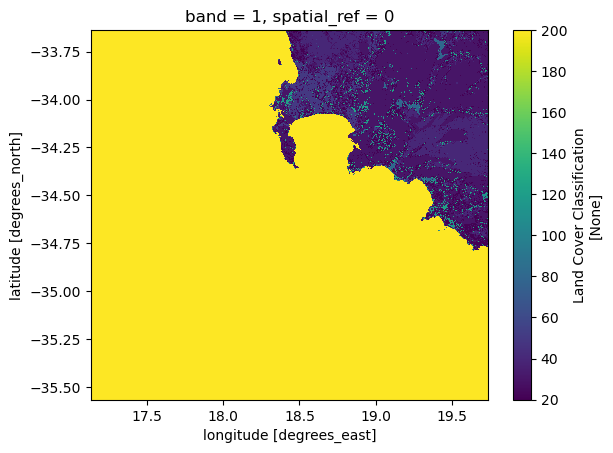

In [16]:
land_cover.squeeze().rio.clip_box(*cloud_dist.rio.reproject("EPSG:4326").rio.bounds()).plot.imshow()

### Auxiliary Data
#### Biome Clusters

In [5]:
import geopandas as gpd

In [8]:
# biome clusters
# see https://zenodo.org/record/5848610#.ZEZ4Py-21qs
biome_clusters = gpd.read_file("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/biome clusters/biome_cluster_shapefile/ProbaV_UTM_LC100_biome_clusters_V3_global.shp")

<Axes: >

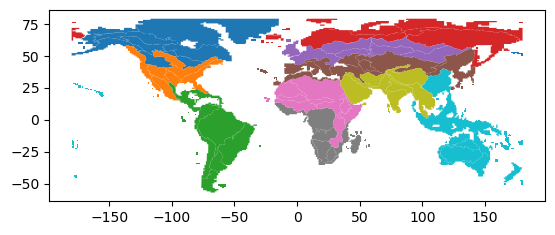

In [14]:
biome_clusters.plot(column = "bc_id")

#### Elevation

In [15]:
import xarray as xr
import rioxarray as rxr

In [17]:
# https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1
elevation = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/DTM/srtm_40_19/srtm_40_19.tif")

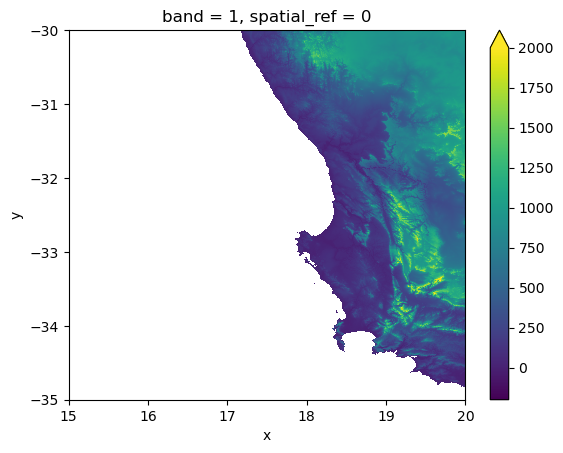

In [20]:
elevation.where(elevation >= -200).squeeze().plot.imshow(vmin = -200, vmax = 2000)

---

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube

In [4]:
raster = make_geocube(
    vector_data = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/Cobertura_uso_terra_Brasil_serie_revisada.shp"),
    measurements = [f"USO{t}" for t in [2000, 2010, 2012, 2014, 2016, 2018, 2020]],
    output_crs = "EPSG:5641",
    resolution = (30, 30),
    fill = -9999
)

KeyboardInterrupt: 

In [ ]:
ftp://geo10.elie.ucl.ac.be/CCI/LandCover/ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992_2015-v2.0.7.zip

In [78]:
c = fiona.open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/Cobertura_uso_terra_Brasil_serie_revisada.shp")
gpd.GeoDataFrame.from_features(c[0:1])

,geometry,INDICE_GRE,USO2000,USO2010,USO2012,USO2014,USO2016,USO2018,USO2020,OBS,ID_GRE
0,"POLYGON ((-52.09503 -32.45742, -52.09510 -32.4...",1KME5189N7749,13,13,13,13,13,13,13,None,11235351897749


In [81]:
len(c)

8752566

In [51]:
land_cover = gpd.read_file("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/land_cover/Cobertura_uso_terra_Brasil_serie_revisada/Cobertura_uso_terra_Brasil_serie_revisada.shp")

KeyboardInterrupt: 

In [39]:
land_cover.set_index("REFNAME", inplace = True)

In [40]:
land_cover

,TEXT,DESCRIèãO,AREA,refn_descr,geometry
REFNAME,,,,,
AC_1.1.7398,AC_1.1.7398,Cidades,1.1033,AC_1.1.7398_Cidades,"POLYGON ((-67.67806 -10.58283, -67.67833 -10.5..."
AC_1.1.7398,AC_1.1.7398,Cidades,0.6579,AC_1.1.7398_Cidades,"POLYGON ((-69.55851 -10.93654, -69.55823 -10.9..."
AC_1.1.7398,AC_1.1.7398,Cidades,3.0128,AC_1.1.7398_Cidades,"POLYGON ((-68.75963 -10.98607, -68.75868 -10.9..."
AC_1.1.7398,AC_1.1.7398,Cidades,0.0036,AC_1.1.7398_Cidades,"POLYGON ((-70.04697 -10.97985, -70.04752 -10.9..."
AC_1.1.7398,AC_1.1.7398,Cidades,0.1215,AC_1.1.7398_Cidades,"POLYGON ((-70.04540 -10.98366, -70.04539 -10.9..."
...,...,...,...,...,...
AC_2.3.1,AC_2.3.1,Pecuária de animais de grande porte,0.1100,AC_2.3.1_Pecuária de animais de grande porte,"POLYGON ((-70.28406 -8.06527, -70.28406 -8.065..."
AC_2.3.1,AC_2.3.1,Pecuária de animais de grande porte,0.0475,AC_2.3.1_Pecuária de animais de grande porte,"POLYGON ((-70.28462 -8.06600, -70.28554 -8.066..."
AC_2.3.1,AC_2.3.1,Pecuária de animais de grande porte,0.0850,AC_2.3.1_Pecuária de animais de grande porte,"POLYGON ((-70.28302 -8.06814, -70.28357 -8.068..."


In [50]:
land_cover["DESCRIèãO"].unique()

array(['Cidades',
       'Cultivos temporários diversificados  + Pecuária animais de pequeno porte  + Extrativismo animal em área florestal',
       'Outros cultivos permanentes',
       'Pecuária de animais de grande porte',
       'Pecuária de animais de grande porte + Cultivos temporários diversificados',
       'Unidades de conservação de proteção integral em área florestal + Pecuária de animais de grande porte + Cultivos tempor',
       'Unidades de conservação de proteção integral em área florestal',
       'Unidades de conservação de uso sustentável  em área florestal',
       'Unidades de conservação de uso sustentável em área florestal + Cultivo agroflorestal',
       'Extrativismo vegetal em área florestal + Extrativismo animal em área florestal',
       'Extrativismo vegetal em área florestal + Cultivos temporários diversificados',
       'Frutíferas permanentes', 'Terra indígena em área florestal',
       'Aquicultura em corpo d\x92água continental',
       'Terra indígena 

<AxesSubplot: >

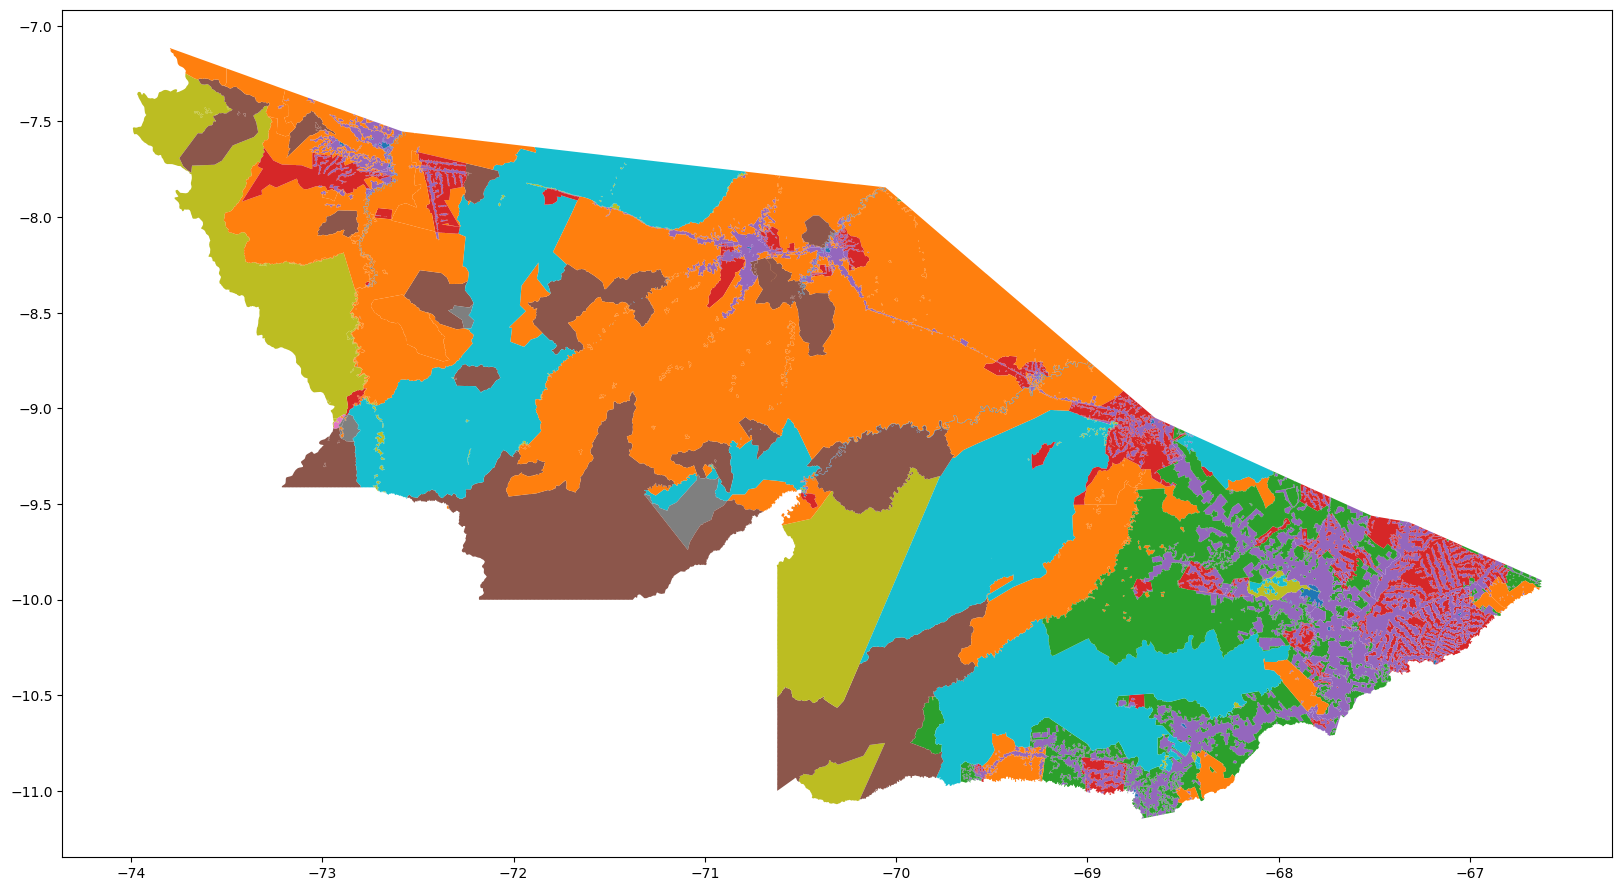

In [48]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20))
land_cover.plot(column = "DESCRIèãO", ax = ax)

In [1]:
import pandas as pd
import geopandas as gpd

lulc = gpd.read_file('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/Cobertura_uso_terra_Brasil_serie_revisada.shp')

KeyboardInterrupt: 

In [2]:
lulc = gpd.read_file('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/Cobertura_uso_terra_Brasil_serie_revisada.shp',
                     rows = 1)

In [3]:
lulc

,INDICE_GRE,USO2000,USO2010,USO2012,USO2014,USO2016,USO2018,USO2020,OBS,ID_GRE,geometry
0,1KME5189N7749,13,13,13,13,13,13,13,None,11235351897749,"POLYGON ((-52.09503 -32.45742, -52.09510 -32.4..."


---

In [5]:
import numpy as np
import shapely
import geopandas as gpd
boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/boundaries/gadm_410-BRA.geojson").to_crs("EPSG:5641")

In [67]:
## create grid

# get boundaries
xmin, ymin, xmax, ymax = np.round(boundaries.total_bounds)

# grid dimensions
# 2**11 pixels times 30 meters per pixel
edge_size = 3328
length = edge_size * 30
width = edge_size * 30

# create grid
cols = list(np.arange(xmin, xmax + width, width))
rows = list(np.arange(ymin, ymax + length, length))


# create polygons for each grid cell
polygons = [shapely.Polygon([(x,y), (x+width, y), (x+width, y+length), (x, y+length)]) for y in rows[:-1] for x in cols[:-1]]

# create geodataframe      
grid = gpd.GeoDataFrame({'geometry': polygons}, crs = 5641)
grid = grid[grid.intersects(boundaries.geometry.iloc[0])]

In [68]:
grid.to_file(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/boundaries/grid_{edge_size}.geojson", driver = "GeoJSON")

In [6]:
grid = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/boundaries/grid.geojson", driver = "GeoJSON")

<Axes: >

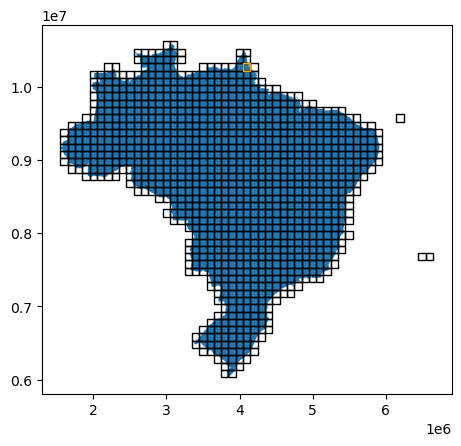

In [69]:
ax = boundaries.plot()
grid.plot(color = "none", edgecolor='black', ax = ax)
grid.iloc[[1000],:].plot(color = "none", edgecolor='orange', ax = ax)
#boundaries[:0].plot(color = "none", edgecolor='red', ax = ax)

In [40]:
import ee
#from geetools import batch

# Trigger the authentication flow.
ee.Authenticate()

True

In [41]:
# Initialize the library.
ee.Initialize(project='master-thesis-414809')

In [42]:
mb_mosaics = ee.ImageCollection('projects/nexgenmap/MapBiomas2/LANDSAT/BRAZIL/mosaics-2')

In [43]:
bands = [
      "blue_median",
      "green_median",
      "red_median",
      "nir_median",
      "swir1_median",
      "swir2_median",
  ]

In [44]:
def format_json(geometry, index):
    tmp = geometry.geometry.iloc[index].exterior.coords.xy
    return [tmp[0][0], tmp[1][0], tmp[0][2], tmp[1][2]]#np.array(json.loads(geometry.to_json())["features"][0]["geometry"]["coordinates"][0])[[0, 2]]
def get_ee_geometry(geometry, index):
    return ee.Geometry.Rectangle(format_json(geometry, index), proj = "EPSG:5641", evenOdd = False)
# def rev_coords(x):
#     return gpd.GeoSeries(shapely.Polygon([list(reversed(y)) for y in x.geometry.iloc[0].exterior.coords]))
# def get_ee_geometry_rev(geometry, index):
#     return ee.Geometry.Rectangle(format_json(rev_coords(geometry.to_crs(4326).iloc[[index]])), proj = "EPSG:4326",evenOdd = False)

In [45]:
#filterBounds(get_ee_geometry(grid, 16)).\ #clip(get_ee_geometry(grid, 16)).\ reproject(crs = "EPSG:5641", scale = 30).\
img = mb_mosaics.\
    filterMetadata("year", "equals", 2015).\
        select(bands).\
            mosaic().\
                int32()

In [45]:
test_settings = {
        "bands": 'red_median,green_median,blue_median',
        "gain": '.2,.2,.2',
        "gamma": 0.75
    }

In [46]:
import geemap.core as geemap

map_l8 = geemap.Map(center=[-8.086605614816632, -72.88518920555826], zoom=10)

# Add the image layer to the map and display it.
map_l8.add_layer(img, test_settings, 'false color composite')
display(map_l8)

Map(center=[-8.086605614816632, -72.88518920555826], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [24]:
projection = img.select("red_median").projection().getInfo()

In [25]:
projection

{'type': 'Projection', 'crs': 'EPSG:5641', 'transform': [30, 0, 0, 0, -30, 0]}

Margin: 24px

Image size: 256px-2*24px=208px

In [61]:
1e13 > (208*(2**12))**2

True

In [70]:
851968 ** 2

725849473024

In [66]:
(208*(2**4))

3328

In [52]:
1e13 > ((6574480.225607567 - 1552328.935599452) / 30) * ((10582639.255444987 - 6031349.390489734) / 30)

True

In [53]:
brazil_bounds = ee.Geometry.Rectangle(boundaries.bounds.to_numpy().tolist()[0], proj = "EPSG:5641", evenOdd = False)

In [54]:
256*4

1024

In [73]:
def export_image(year = 2015):
    task = ee.batch.Export.image.toCloudStorage(
        image=img,
        description=f'mapbiomas_{year}',
        bucket="master-thesis-lulc",
        fileNamePrefix=f'mapbiomas/{year}_',
        scale=30,
        maxPixels=1e13,
        crs="EPSG:5641",
        crsTransform=[30, 0, 0, 0, -30, 0],
        shardSize=208,
        fileDimensions=[3328, 3328],
        region=brazil_bounds,
        fileFormat='GeoTIFF'
        )
    task.start()

In [74]:
export_image()

In [13]:
import xarray as xr
import rioxarray as rxr

In [38]:
dat = rxr.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/mapbiomas_2015_0.tif")

In [47]:
dat

<xarray.DataArray (band: 6, y: 8193, x: 8193)> Size: 2GB
array([[[ 222,  232, ...,  223,  217],
        [ 224,  233, ...,  246,  219],
        ...,
        [   0,    0, ...,    0,    0],
        [   0,    0, ...,    0,    0]],

       [[ 570,  589, ...,  427,  414],
        [ 584,  595, ...,  468,  447],
        ...,
        [   0,    0, ...,    0,    0],
        [   0,    0, ...,    0,    0]],

       ...,

       [[1939, 2039, ..., 1499, 1418],
        [2055, 2119, ..., 1733, 1519],
        ...,
        [   0,    0, ...,    0,    0],
        [   0,    0, ...,    0,    0]],

       [[ 920,  946, ...,  732,  655],
        [ 959,  973, ...,  825,  709],
        ...,
        [   0,    0, ...,    0,    0],
        [   0,    0, ...,    0,    0]]], dtype=int32)
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 66kB 3.518e+06 3.518e+06 ... 3.764e+06 3.764e+06
  * y            (y) float64 66kB 6.277e+06 6.277e+06 ... 6.031e+06 6.031e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('blue_median', 'green_median', 'red_median', 'nir_median...

In [44]:
dat.isin(0).sum()

<xarray.DataArray ()> Size: 8B
array(376607345)
Coordinates:
    spatial_ref  int64 8B 0

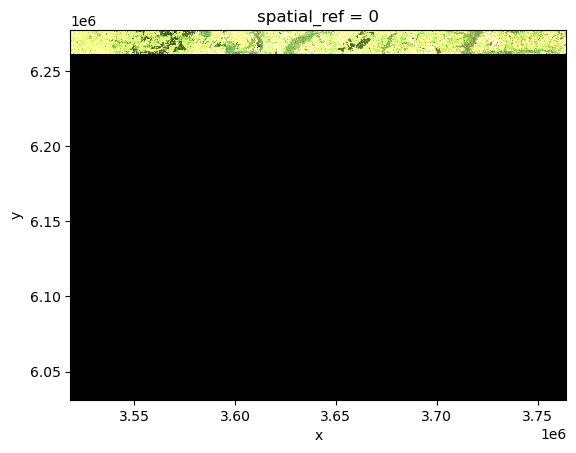

In [40]:
xr.plot.imshow(dat.sel(band = [3,2,1]), rgb = "band", robust = True)

In [1]:
import tensorflow as tf

2024-02-24 11:47:01.628217: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 11:47:02.098337: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 11:47:02.955931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 11:47:02.955976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 11:47:02.958861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
dataset = tf.data.TFRecordDataset("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/mapbiomas_2015_100-1.tfrecord")